In [1]:
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install seaborn
!pip install sklearn
!pip install transformers

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/torch-2.6.0+computecanada-cp310-cp310-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/filelock-3.17.0+computecanada-py3-none-any.whl (from torch)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/networkx-3.4.2+computecanada-py3-none-any.whl (from torch)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/fsspec-2025.2.0+computecanada-py3-none-any.whl (from torch)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/sympy-1.13.1+computecanada-py3-none-any.whl (from torch)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3+computecanada
    Not uni

In [2]:
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Normalize,
    CenterCrop,
    Resize
)
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

import numpy as np
# from skimage import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import pandas as pd
import ast
import cv2

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

In [3]:
torch.cuda.set_device("cuda:0")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

DEVICE: cuda


In [5]:
run_name = 'simclr_rad-dino_pos-pairs_aug-pairs_100_epoch_'

In [6]:
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 100
        self.batch_size = 70  # Adjust as needed
        self.patience = 30
        self.dropout_p = 0.3
        self.image_shape = [256, 256]
        self.kernel_size = [21, 21]  # For the transforms, 10% of image size
        self.embedding_size = 128
        self.scheduler_step_size = 70
        self.scheduler_gamma = 0.1
        self.weight_decay = 1e-5
        self.max_norm = 1.0  # Gradient clipping
        self.temperature = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.base_path = f"/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/{run_name}"
        os.makedirs(self.base_path, exist_ok=True)
        self.best_model_path = os.path.join(self.base_path, "best_model.pth")
        self.last_model_path = os.path.join(self.base_path, "last_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")

config = Config()

In [7]:
from enum import Enum
from torchvision import transforms
from PIL import Image, ImageEnhance, ImageOps
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

def convert_to_rgb(img):
    """
    Convert an image to RGB.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The same image in RGB.
    """
    return img.convert("RGB")

def convert_to_ycbcr(img):
    """
    Convert an image to YCbCr.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The same image in YCbCr.
    """
    return img.convert("YCbCr")



class RandomAdjustSharpness:
    def __init__(self, factor_low, factor_high):
        """
        Adjust image sharpness with factor randomly chosen between factor_low
        and factor_high. A factor of 0 gives blurred image and a factor of 1
        gives the original image.

        Args:
            factor_low (float): The lower bound of the sharpness factor.
            factor_high (float): The upper bound of the sharpness factor.
        """
        self.factor_low = factor_low
        self.factor_high = factor_high

    def __call__(self, img):
        factor = np.random.uniform(self.factor_low, self.factor_high)
        return ImageEnhance.Sharpness(img).enhance(factor)


# class RandomEqualize:
#     def __init__(self, p=0.5):
#         """
#         Equalise the image histogram. Can be applied to colour images by
#         converting to YCbCr format first (which separates raw intensity from
#         other channels), applying equalisation, then converting back to RGB.

#         Args:
#             p (float, optional): The probability of applying equalization.
#                 Defaults to 0.5.
#         """
#         self.p = p

#     def __call__(self, img):
#         if np.random.rand() < self.p:
#             img = convert_to_ycbcr(img)
#             y, cb, cr = img.split()
#             y_eq = ImageOps.equalize(y)
#             img = Image.merge("YCbCr", (y_eq, cb, cr))
#             img = convert_to_rgb(img)
#             return img
#         return img



class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


class AugmentationSequenceType(Enum):
    """
    Augmentation sequence for SimCLR pretraining
    """
    NATURAL = "natural"
    SIMPLE = "simple"
    NOVEL = "novel"
    NOVEL_GREYSCALE = "greyscale"
    temp = "temp"
    normal = 'normal'

augmentation_sequence_map = {

    AugmentationSequenceType.NOVEL_GREYSCALE.value: transforms.Compose([
        transforms.Resize((224, 224)),
        # Normalise to 3 channels (Convert grayscale to RGB)
        transforms.Lambda(convert_to_rgb),
        # Transformation 1: random horizontal flip
        transforms.RandomHorizontalFlip(),
        # # Transformation 2: crop-and-resize
        # transforms.RandomResizedCrop(size=28),
        # # Transformation 3: Gaussian blur
        # transforms.GaussianBlur(kernel_size=9),
        # # Transformation 4: Histogram equalisation and sharpness to tackle low contrast
        # RandomEqualize(0.5),
        # RandomAdjustSharpness(factor_low=1, factor_high=10),

        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]),

    
    AugmentationSequenceType.temp.value: transforms.Compose([
        transforms.Resize((config.image_shape[0], config.image_shape[1])),
        transforms.Lambda(convert_to_rgb),
       
        # Rotate the image by a random angle within ±15°
        transforms.RandomRotation(degrees=10),
        
        # Randomly flip horizontally and vertically (if clinically acceptable)
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        
        transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=random.uniform(1, 1.3))),
        # Convert image to a tensor (results in a 1-channel tensor for grayscale)
        transforms.ToTensor(),

        ]),

        AugmentationSequenceType.normal.value: transforms.Compose([
        transforms.Resize((config.image_shape[0], config.image_shape[1])),
        transforms.Lambda(convert_to_rgb),
       
        transforms.ToTensor(),

        ]),
}


In [8]:
class ContrastiveLearningViewGenerator(object):
    """Take an image (or a batch of images) and return
    n_views (2 by default) which are the result of applying
    the base_transform. That transform has random transformations
    which alter the images differently."""

    def __init__(self, base_transform,normal_transform, n_views=2):
        self.base_transform = base_transform
        self.normal_transform = normal_transform
        self.n_views = n_views

    # def __call__(self, x):
    #     views = [self.base_transform(x) for i in range(self.n_views)]
    #     views = [self.normal_transform(x),self.base_transform(x)]
    #     return views

    def __call__(self, x):
        # Randomly choose between generating all views from base_transform or a fixed pair of normal/base transforms
        if random.random() < 0.5:
            views = [self.base_transform(x) for _ in range(self.n_views)]
        else:
            views = [self.normal_transform(x), self.base_transform(x)]
        return views

In [23]:
class CombinedContrastiveDataset(Dataset):
    def __init__(self, list_images, positive_pairs,negative_pairs, base_transform, normal_transform):
        self.list_images = list_images
        self.positive_pairs = positive_pairs
        self.negative_pairs = negative_pairs
        self.base_transform = base_transform
        self.normal_transform = normal_transform
        self.all_images = self.positive_pairs + self.negative_pairs + self.list_images

        # Create a view generator for on-the-fly pair generation
        self.view_generator = ContrastiveLearningViewGenerator(base_transform, normal_transform, n_views=2)
        
    def __len__(self):
        # You can choose how many examples to yield; for instance, 
        # sum of individual images and positive pairs (or sample randomly)
        return len(self.all_images )
    
    def __getitem__(self, idx):
        # For simplicity, let’s say the first part of the dataset is explicit pairs
        if idx < len(self.positive_pairs):
            img_path1, img_path2 =  self.all_images[idx]
            img1 = Image.open(img_path1)
            img2 = Image.open(img_path2)
            
            img1 = self.normal_transform(img1)  # or base_transform if you prefer
            img2 = self.normal_transform(img2)
            return [img1, img2]
 
        elif (idx >= len(self.positive_pairs)) and (idx < len(self.negative_pairs) + len(self.positive_pairs)):
            img_path1, img_path2 =  self.all_images[idx]
            img1 = Image.open(img_path1)
            img2 = Image.open(img_path2)
            
            img1 = self.normal_transform(img1)  # or base_transform if you prefer
            img2 = self.normal_transform(img2)
            return [img1, img2]
        
        else:
            # For the rest, sample a single image and generate two views.
            img_path = self.list_images[idx]
            img = Image.open(img_path)
            views = self.view_generator(img)
            return views


In [24]:
# class CustomDataset(Dataset):
#     """Image dataset class."""

#     def __init__(self, list_images, transform=None):
#         """
#         Args:
#             list_images (list): List of all the images,
#                 e.g., obtained with glob.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample/batch.
#         """
#         self.list_images = list_images
#         self.transform = transform

#     def __len__(self):
#         return len(self.list_images)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = self.list_images[idx]
#         # image = io.imread(img_name) # np.ndarray, RGB-image WxHxC
#         image = Image.open(img_name)
#         if self.transform:
#             image = self.transform(image) # CxWxH, transformed

#         return image

In [25]:
images_list_train = []
for i in ['es','ed']:
  path = f'/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/{i}/images/'
  images = [path+i for i in os.listdir(path)]
  images_list_train += images

In [26]:
def train_val_test_split(list_filenames, train_size=0.7):

    list_filenames_train, list_filenames_val = train_test_split(list_filenames,
                                                                      train_size=train_size,
                                                                      shuffle=True,
                                                                      random_state=42)


    return list_filenames_train, list_filenames_val

list_images = images_list_train
list_images_train, list_images_val = train_val_test_split(list_images)

In [27]:
print("Total number of images: ", len(list_images))
print("Images in train split: ", len(list_images_train))
print("Images in validation split: ", len(list_images_val))

Total number of images:  1902
Images in train split:  1331
Images in validation split:  571


In [28]:
import re
from collections import defaultdict


def create_positive_pairs(images): 
    file_list = sorted(images)
    pattern = re.compile(r'patient(\d+)_frame(\d+)_slice_(\d+)\.png')
    
    # Group images by (patient, frame)
    groups = defaultdict(list)
    for path in file_list:
        # Get just the file name
        filename = os.path.basename(path)
        match = pattern.search(filename)
        if match:
            patient = match.group(1)      # e.g. "001"
            frame = match.group(2)        # e.g. "01" or "12"
            slice_num = int(match.group(3))
            key = (patient, frame)
            groups[key].append((slice_num, path))
        else:
            print(f"File {path} does not match the expected pattern.")
    
    # Create positive pairs by pairing adjacent slices within each (patient, frame) group.
    positive_pairs = []
    for key, slices in groups.items():
        # Sort images by slice number within the group
        slices.sort(key=lambda x: x[0])
        # Create a pair for each adjacent slice only if more than one image exists
        for i in range(len(slices) - 1):
            img1 = slices[i][1]
            img2 = slices[i + 1][1]
            if (eval(img1.split('_')[-1].replace('.png','')) + 1) == eval(img2.split('_')[-1].replace('.png','')):
                positive_pairs.append((img1, img2))
        # else:
            # print(img1,'\n',img2)
            # print('\n\n')
    return positive_pairs


In [97]:
def create_negative_pairs(images):
    file_list = sorted(images)
    pattern = re.compile(r'patient(\d+)_frame(\d+)_slice_(\d+)\.png')
    
    # Group images by (patient, frame)
    groups = defaultdict(list)
    for path in file_list:
        filename = os.path.basename(path)
        match = pattern.search(filename)
        if match:
            patient = match.group(1)
            frame = match.group(2)
            slice_num = int(match.group(3))
            key = (patient, frame)
            groups[key].append((slice_num, path))
        else:
            print(f"File {path} does not match the expected pattern.")
    
    negative_pairs = []
    
    # Intra-group non-consecutive pairs (same patient and frame, slices not adjacent)
    for key, slices in groups.items():
        slices.sort(key=lambda x: x[0])  # Sort by slice number
        for i in range(len(slices)):
            for j in range(i + 1, len(slices)):
                slice_num1 = slices[i][0]
                slice_num2 = slices[j][0]
                if slice_num2 - slice_num1 >= 9:
                    negative_pairs.append((slices[i][1], slices[j][1]))

    # Inter-group pairs with controlled combinations
    groups_list = list(groups.items())
    for i in range(len(groups_list)):
        key1, slices1 = groups_list[i]
        
        # Select representative slices from group1 (first, last)
        slices1_sorted = sorted(slices1, key=lambda x: x[0])
        group1_samples = [slices1_sorted[0]]  # Always include first slice
        if len(slices1_sorted) > 1:
            group1_samples.append(slices1_sorted[-1])  # Add last slice if exists
        
        for j in range(i + 170, len(groups_list)):
            key2, slices2 = groups_list[j]
            if key1 != key2:
                # Select representative slices from group2 (first, last)
                slices2_sorted = sorted(slices2, key=lambda x: x[0])
                group2_samples = [slices2_sorted[0]]
                if len(slices2_sorted) > 1:
                    group2_samples.append(slices2_sorted[-1])
                
                # Create limited combinations
                for s1 in group1_samples:
                    for s2 in group2_samples:
                        # Add pair if slices are from different patients
                        if key1[0] != key2[0]:  # Different patients
                            negative_pairs.append((s1[1], s2[1]))
    return negative_pairs

In [98]:
pos_pairs_train = create_positive_pairs(list_images_train)
pos_pairs_val = create_positive_pairs(list_images_val)

In [99]:
neg_pairs_train = create_negative_pairs(list_images_train)
neg_pairs_val = create_negative_pairs(list_images_val)

In [100]:
output_shape = config.image_shape 

base_transforms = augmentation_sequence_map[AugmentationSequenceType.temp.value]
normal_transforms = augmentation_sequence_map[AugmentationSequenceType.normal.value]

image_ds_train = CombinedContrastiveDataset(
    list_images=list_images_train,
    positive_pairs=pos_pairs_train,
    negative_pairs=neg_pairs_train,
    base_transform=base_transforms,
    normal_transform=normal_transforms)

image_ds_val = CombinedContrastiveDataset(
    list_images=list_images_val,
    positive_pairs=pos_pairs_val,
    negative_pairs=neg_pairs_val,
    base_transform=base_transforms,
    normal_transform=normal_transforms)

In [101]:
len(image_ds_train)

4300

In [102]:
len(image_ds_val)

1579

In [12]:
# # The size of the images
# output_shape = config.image_shape 

# # base_transforms = augmentation_sequence_map[AugmentationSequenceType.NOVEL_GREYSCALE.value]
# base_transforms = augmentation_sequence_map[AugmentationSequenceType.temp.value]
# normal_transforms = augmentation_sequence_map[AugmentationSequenceType.normal.value]
# custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms,normal_transform=normal_transforms)

# image_ds_train = CustomDataset(
#     list_images=list_images_train,
#     transform=custom_transform
# )

# image_ds_val = CustomDataset(
#     list_images=list_images_val,
#     transform=custom_transform
# )

# image_ds_test = CustomDataset(
#     list_images=list_images_test,
#     transform=custom_transform
# )

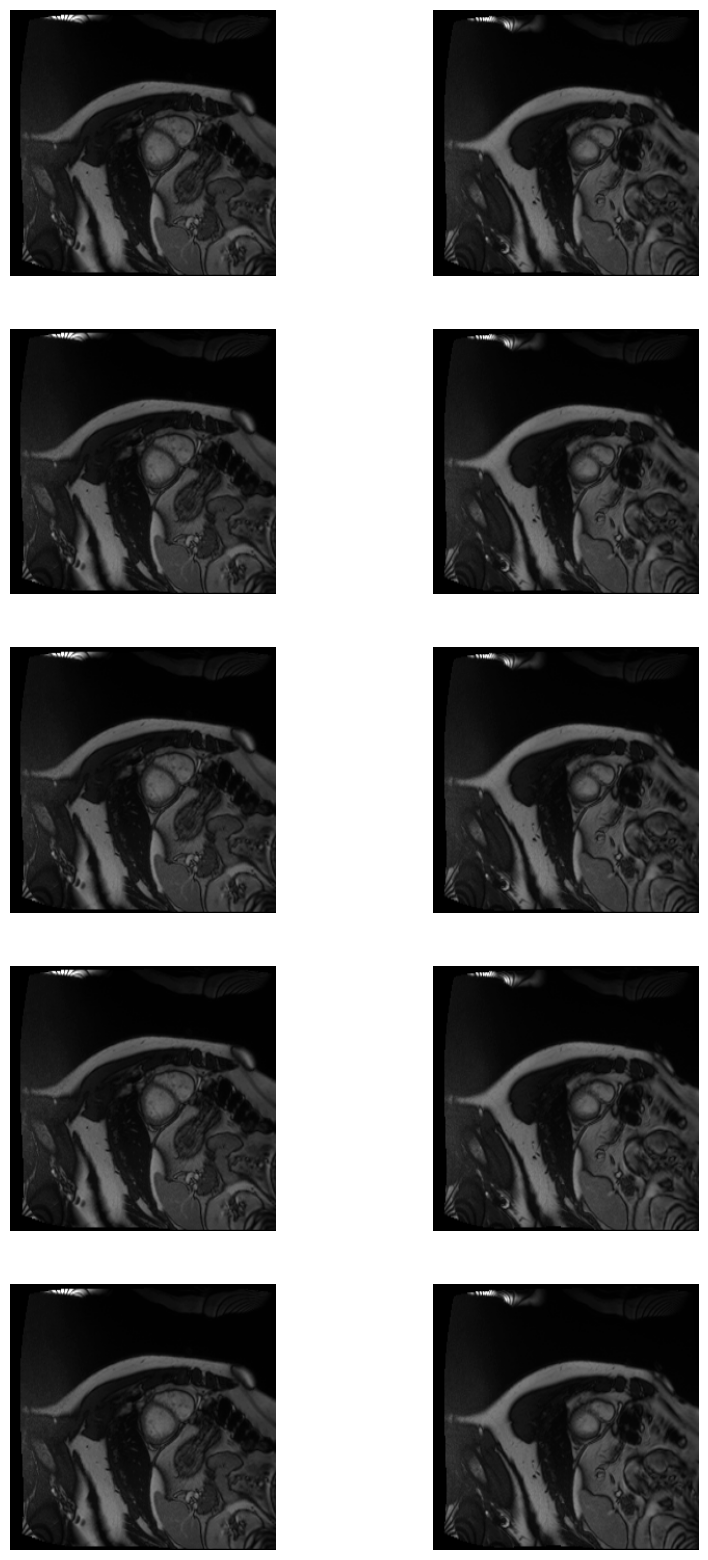

In [103]:
def view_data(image_ds, index):
    plt.figure(figsize=(10,20))
    for i in range(1,6):
        images = image_ds[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0),cmap='gray')
        plt.axis(False)
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0),cmap='gray')
        plt.axis(False)

view_data(image_ds_train,400)

In [20]:
BATCH_SIZE = config.batch_size # 128 # 16 #128

# Building the data loader(s)
train_loader = torch.utils.data.DataLoader(
    image_ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    image_ds_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# test_loader = torch.utils.data.DataLoader(
#     image_ds_test,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     #num_workers=os.cpu_count(),
#     drop_last=True,
#     pin_memory=True,
# )

In [21]:
print("Batches in TRAIN: ", len(train_loader))
print("Batches in VAL: ", len(val_loader))
# print("Batches in TEST: ", len(test_loader))

Batches in TRAIN:  30
Batches in VAL:  10


In [22]:
import torch
import torch.nn as nn
from transformers import Dinov2Model

In [23]:
class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size

        # Load the DINOv2 model
        # self.encoder = Dinov2Model.from_pretrained('facebook/dinov2-base')
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino')
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, 256),  # DINOv2 base model has an embedding dimension of 768
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        if not self.linear_eval:
            # We expect x to be a list of two views
            # We concatenate both views to be one large batch
            # of size 2*batch_size, i.e., (2*B, C, W, H)
            x = torch.cat(x, dim=0)

        # DINOv2 expects inputs of shape (batch_size, num_channels, height, width)
        # Ensure x is properly normalized and resized as required by DINOv2

        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]  # Extract the [CLS] token representation

        # If not linear_eval: Projections: (2*B, E), they are concatenated
        # Else: (B, E)
        projection = self.projection(encoding)

        return projection


In [24]:
def save_model(model, save_path):

    # Save the encoder (DINOv2 model)
    model.encoder.save_pretrained(save_path)

    # Save the projection head
    torch.save(model.projection.state_dict(), os.path.join(save_path, 'projection_head.pth'))

def load_model(model_class, load_path, device):
    # Load the encoder (DINOv2 model)
    encoder = Dinov2Model.from_pretrained(load_path)

    # Initialize your custom model
    model = model_class()
    model.encoder = encoder

    # Load the projection head
    projection_head_path = os.path.join(load_path, 'projection_head.pth')
    model.projection.load_state_dict(torch.load(projection_head_path, map_location=device))

    return model


In [25]:
# Plot training function
def plot_training(train_loss_history, save_path, val_loss_history=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    if val_loss_history is not None:
        plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_path) # config.learning_plot_path
    plt.show()

In [26]:
def contrastrive_loss(features, config):
    """NT-Xent (Normalized Temperature-Scaled Cross Entropy) Loss,
    aka. Contrastive Loss, used in the SimCLR paper.

    IMPORTANT NOTE: We don't really return the loss, but the logits
    and the (synthetic) labels to compute it with CrossEntropyLoss!

    The main idea behind SimCLR and contrastive learning is to learn
    representations that are close for positive pairs and far for negative pairs.
    In the case of SimCLR, a positive pair is two different augmentations
    of the same image, and a negative pair is two augmentations
    of two different images.

    How NT-Xent works:
    - Compute the cosine similarity between the representations
    of all pairs of images in the batch.
    - Apply a softmax to these similarities, but treat the similarity
    of each image with its positive pair as the correct class.
    This means that for each image, the goal is to make the
    softmax probability of its positive pair as high as possible,
    and the softmax probabilities of its negative pairs as low as possible.
    - Compute the cross entropy between these softmax probabilities
    and the true labels (which have a 1 for the positive pair
    and 0 for the negative pairs).
    - The temperature parameter scales the similarities before the softmax.
    A lower temperature makes the softmax output more peaky
    (i.e., the highest value will be much higher than the others,
    and the lower values will be closer to zero),
    while a higher temperature makes the softmax output more uniform.

    Args:
        projections: cat(z1, z2)
        z1: The projection of the first branch/view
        z2: The projeciton of the second branch/view

    Returns:
        the NTxent loss

    Notes on the shapes:
        inputs to model (views): [(B, C, W, H), (B, C, W, H)]
            B: batch size
            C: channels
            W: width
            H: height
            E: embedding size
        outputs from model (projections): [2*B, E]
        LABELS: [2*B, 2*B]
        features = outputs from model: [2*B, E]
        mask: [2*B, 2*B]
        similarity_matrix: [2*B, 2*B-1]
        positives: [2*B, 1]
        negatives: [2*B, 2*B-2]
        logits: [2*B, 2*B-1]
        labels: [2*B]
    """
    # FIXME: Refactor: take config out and pass necessary params, remove capital variables, etc.
    # FIXME: convert into class
    BATCH_SIZE = config.batch_size
    DEVICE = config.device
    TEMPERATURE = config.temperature

    LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
    LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
    LABELS = LABELS.to(DEVICE) # 2*B, 2*B

    similarity_matrix = torch.matmul(features, features.T) # 2*B, 2*B
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 2*B, 2*B-1
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-1

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 2*B, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-2

    logits = torch.cat([positives, negatives], dim=1) # 2*B, 2*B-1
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / TEMPERATURE

    return logits, labels

In [ ]:
model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to(config.device)
criterion = nn.CrossEntropyLoss().to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)

In [27]:
# Validation function
def validate(model, val_loader, criterion, config):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for views in val_loader:
            projections = model([view.to(config.device) for view in views])
            logits, labels = contrastrive_loss(projections, config)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, output_freq=2, debug=False):
    model = model.to(config.device)
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    total_batches = len(train_loader)
    print_every = total_batches // output_freq  # Print every 1/output_freq of total batches

    for epoch in tqdm(range(config.num_epochs)):
        start_time = time.time()
        train_loss = 0.0
        model.train()

        for i, views in enumerate(train_loader):
            projections = model([view.to(config.device) for view in views])
            logits, labels = contrastrive_loss(projections, config)
            if debug and torch.isnan(logits).any() or torch.isinf(logits).any():
                print("[WARNING]: large logits")
                print(logits)
                logits = logits.clamp(min=-10, max=10)  # Adjust these values as necessary
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_norm)
            optimizer.step()

            train_loss += loss.item()

            # # Print training loss
            # if i % print_every == 0:
            #     print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")

        scheduler.step()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        val_loss = validate(model, val_loader, criterion, config)
        val_loss_history.append(val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch: {epoch+1}, Loss: {train_loss}, Val Loss: {val_loss}, Time: {epoch_time}s, Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save last model
        save_model(model, config.last_model_path)

        # Save best model & early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config.best_model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= config.patience:
                print("Early stopping")
                break

    return train_loss_history, val_loss_history

In [ ]:
train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 4.962417828409295, Val Loss: 4.919529557228088, Time: 63.88102459907532s, Learning Rate: 0.001


  1%|▍                                        | 1/100 [01:05<1:47:35, 65.20s/it]

Epoch: 2, Loss: 4.951784510361521, Val Loss: 4.913580596446991, Time: 63.024282932281494s, Learning Rate: 0.001


  2%|▊                                        | 2/100 [02:09<1:45:40, 64.69s/it]

Epoch: 3, Loss: 4.934751033782959, Val Loss: 4.773217499256134, Time: 63.08735990524292s, Learning Rate: 0.001


  3%|█▏                                       | 3/100 [03:13<1:44:23, 64.58s/it]

Epoch: 4, Loss: 4.599814866718493, Val Loss: 3.673453629016876, Time: 63.21114635467529s, Learning Rate: 0.001


  4%|█▋                                       | 4/100 [04:18<1:43:17, 64.55s/it]

Epoch: 5, Loss: 4.497643094313772, Val Loss: 3.399300307035446, Time: 63.342819929122925s, Learning Rate: 0.001


  5%|██                                       | 5/100 [05:23<1:42:15, 64.59s/it]

Epoch: 6, Loss: 3.7553008230108964, Val Loss: 3.187853753566742, Time: 63.61105227470398s, Learning Rate: 0.001


  6%|██▍                                      | 6/100 [06:28<1:41:22, 64.70s/it]

Epoch: 7, Loss: 3.3293873636346114, Val Loss: 3.001501351594925, Time: 63.24475312232971s, Learning Rate: 0.001


  7%|██▊                                      | 7/100 [07:32<1:40:12, 64.65s/it]

Epoch: 8, Loss: 3.2750828893561112, Val Loss: 3.153662145137787, Time: 63.31207489967346s, Learning Rate: 0.001


  8%|███▎                                     | 8/100 [08:36<1:38:47, 64.43s/it]

Epoch: 9, Loss: 3.1633778496792444, Val Loss: 2.8767245709896088, Time: 63.69649386405945s, Learning Rate: 0.001


  9%|███▋                                     | 9/100 [09:41<1:37:59, 64.61s/it]

Epoch: 10, Loss: 3.117163996947439, Val Loss: 2.7002191841602325, Time: 63.3843891620636s, Learning Rate: 0.001


 10%|████                                    | 10/100 [10:46<1:36:57, 64.64s/it]

Epoch: 11, Loss: 3.3631881914640727, Val Loss: 3.3206793665885925, Time: 63.317951917648315s, Learning Rate: 0.001


 11%|████▍                                   | 11/100 [11:50<1:35:35, 64.44s/it]

Epoch: 12, Loss: 3.335316582729942, Val Loss: 2.8842543363571167, Time: 63.187294483184814s, Learning Rate: 0.001


 12%|████▊                                   | 12/100 [12:54<1:34:14, 64.26s/it]

Epoch: 13, Loss: 3.1141559952183773, Val Loss: 2.8295282125473022, Time: 63.264307498931885s, Learning Rate: 0.001


 13%|█████▏                                  | 13/100 [13:58<1:33:01, 64.16s/it]

Epoch: 14, Loss: 3.0315269294537996, Val Loss: 2.7708387672901154, Time: 63.20057559013367s, Learning Rate: 0.001


 14%|█████▌                                  | 14/100 [15:01<1:31:49, 64.07s/it]

Epoch: 15, Loss: 3.0206965396278784, Val Loss: 2.7967265844345093, Time: 63.33618950843811s, Learning Rate: 0.001


 15%|██████                                  | 15/100 [16:05<1:30:43, 64.05s/it]

Epoch: 16, Loss: 3.0643432767767655, Val Loss: 2.6342829167842865, Time: 63.320531368255615s, Learning Rate: 0.001


 16%|██████▍                                 | 16/100 [17:10<1:29:54, 64.22s/it]

Epoch: 17, Loss: 2.998617636530023, Val Loss: 2.5961276590824127, Time: 63.36870265007019s, Learning Rate: 0.001


 17%|██████▊                                 | 17/100 [18:15<1:29:01, 64.36s/it]

Epoch: 18, Loss: 2.9217703844371594, Val Loss: 2.557050406932831, Time: 63.277188301086426s, Learning Rate: 0.001


 18%|███████▏                                | 18/100 [19:19<1:28:04, 64.44s/it]

Epoch: 19, Loss: 2.8790320471713415, Val Loss: 2.532577931880951, Time: 63.33961057662964s, Learning Rate: 0.001


 19%|███████▌                                | 19/100 [20:24<1:27:04, 64.50s/it]

Epoch: 20, Loss: 2.9332932171068693, Val Loss: 2.4580774307250977, Time: 63.17461442947388s, Learning Rate: 0.001


 20%|████████                                | 20/100 [21:28<1:26:00, 64.50s/it]

Epoch: 21, Loss: 2.8309138574098287, Val Loss: 2.509739428758621, Time: 63.2265887260437s, Learning Rate: 0.001


 21%|████████▍                               | 21/100 [22:32<1:24:41, 64.32s/it]

Epoch: 22, Loss: 2.9244196289464046, Val Loss: 2.695873945951462, Time: 63.30967116355896s, Learning Rate: 0.001


 22%|████████▊                               | 22/100 [23:36<1:23:28, 64.21s/it]

Epoch: 23, Loss: 2.966211281324688, Val Loss: 2.760171264410019, Time: 63.15442228317261s, Learning Rate: 0.001


 23%|█████████▏                              | 23/100 [24:40<1:22:15, 64.10s/it]

Epoch: 24, Loss: 2.849317249498869, Val Loss: 2.6318523585796356, Time: 63.33450675010681s, Learning Rate: 0.001


 24%|█████████▌                              | 24/100 [25:44<1:21:08, 64.07s/it]

Epoch: 25, Loss: 2.870208376332333, Val Loss: 2.5197936594486237, Time: 63.08404278755188s, Learning Rate: 0.001


 25%|██████████                              | 25/100 [26:48<1:19:57, 63.97s/it]

Epoch: 26, Loss: 2.7793603194387337, Val Loss: 2.701394259929657, Time: 63.183167457580566s, Learning Rate: 0.001


 26%|██████████▍                             | 26/100 [27:52<1:18:50, 63.93s/it]

Epoch: 27, Loss: 2.8470423221588135, Val Loss: 2.44164177775383, Time: 63.06662559509277s, Learning Rate: 0.001


 27%|██████████▊                             | 27/100 [28:56<1:17:56, 64.06s/it]

Epoch: 28, Loss: 2.8748429448981034, Val Loss: 2.6692868769168854, Time: 63.274214029312134s, Learning Rate: 0.001


 28%|███████████▏                            | 28/100 [30:00<1:16:49, 64.02s/it]

Epoch: 29, Loss: 2.971932160226922, Val Loss: 2.563689738512039, Time: 63.231011629104614s, Learning Rate: 0.001


 29%|███████████▌                            | 29/100 [31:04<1:15:42, 63.98s/it]

Epoch: 30, Loss: 2.8645570780101575, Val Loss: 2.5226910412311554, Time: 62.97342252731323s, Learning Rate: 0.001


 30%|████████████                            | 30/100 [32:08<1:14:31, 63.88s/it]

Epoch: 31, Loss: 2.7376304676658227, Val Loss: 2.494159996509552, Time: 63.03983283042908s, Learning Rate: 0.001


 31%|████████████▍                           | 31/100 [33:11<1:13:23, 63.82s/it]

Epoch: 32, Loss: 2.824007122140182, Val Loss: 2.5606323778629303, Time: 63.05544662475586s, Learning Rate: 0.001


 32%|████████████▊                           | 32/100 [34:15<1:12:17, 63.79s/it]

Epoch: 33, Loss: 2.7368405367198743, Val Loss: 2.4047346115112305, Time: 63.07914209365845s, Learning Rate: 0.001


 33%|█████████████▏                          | 33/100 [35:19<1:11:25, 63.97s/it]

Epoch: 34, Loss: 2.733189319309435, Val Loss: 2.4051819145679474, Time: 62.991363286972046s, Learning Rate: 0.001


 34%|█████████████▌                          | 34/100 [36:23<1:10:15, 63.87s/it]

Epoch: 35, Loss: 2.6960469547070955, Val Loss: 2.416831076145172, Time: 63.14843726158142s, Learning Rate: 0.001


 35%|██████████████                          | 35/100 [37:27<1:09:10, 63.85s/it]

Epoch: 36, Loss: 2.659721110996447, Val Loss: 2.2734096348285675, Time: 63.38292598724365s, Learning Rate: 0.001


 36%|██████████████▍                         | 36/100 [38:32<1:08:22, 64.10s/it]

Epoch: 37, Loss: 2.6839817448666223, Val Loss: 2.3197789192199707, Time: 63.18943786621094s, Learning Rate: 0.001


 37%|██████████████▊                         | 37/100 [39:35<1:07:13, 64.02s/it]

Epoch: 38, Loss: 2.664508192162765, Val Loss: 2.4180492758750916, Time: 62.97498083114624s, Learning Rate: 0.001


 38%|███████████████▏                        | 38/100 [40:39<1:06:02, 63.90s/it]

Epoch: 39, Loss: 2.686718037253932, Val Loss: 2.3686572313308716, Time: 63.02247929573059s, Learning Rate: 0.001


 39%|███████████████▌                        | 39/100 [41:43<1:04:54, 63.84s/it]

Epoch: 40, Loss: 2.7166264684576737, Val Loss: 2.3395306766033173, Time: 63.107977628707886s, Learning Rate: 0.001


 40%|████████████████                        | 40/100 [42:46<1:03:48, 63.81s/it]

Epoch: 41, Loss: 2.722619972730938, Val Loss: 2.4799883365631104, Time: 63.004164934158325s, Learning Rate: 0.001


 41%|████████████████▍                       | 41/100 [43:50<1:02:42, 63.77s/it]

Epoch: 42, Loss: 2.7378716970744885, Val Loss: 2.318275421857834, Time: 62.956573724746704s, Learning Rate: 0.001


 42%|████████████████▊                       | 42/100 [44:54<1:01:35, 63.72s/it]

Epoch: 43, Loss: 2.690926714947349, Val Loss: 2.5447947680950165, Time: 62.99427247047424s, Learning Rate: 0.001


 43%|█████████████████▏                      | 43/100 [45:57<1:00:30, 63.70s/it]

Epoch: 44, Loss: 2.64484305130808, Val Loss: 2.317281574010849, Time: 63.017149925231934s, Learning Rate: 0.001


 44%|██████████████████▍                       | 44/100 [47:01<59:26, 63.69s/it]

Epoch: 45, Loss: 2.651364702927439, Val Loss: 2.352291166782379, Time: 63.08674073219299s, Learning Rate: 0.001


 45%|██████████████████▉                       | 45/100 [48:05<58:23, 63.71s/it]

Epoch: 46, Loss: 2.639486049350939, Val Loss: 2.2209844291210175, Time: 62.97740912437439s, Learning Rate: 0.001


 46%|███████████████████▎                      | 46/100 [49:09<57:29, 63.87s/it]

Epoch: 47, Loss: 2.6309792619002494, Val Loss: 2.4493768215179443, Time: 63.07423186302185s, Learning Rate: 0.001


 47%|███████████████████▋                      | 47/100 [50:13<56:23, 63.83s/it]

Epoch: 48, Loss: 2.62838844249123, Val Loss: 2.2721704244613647, Time: 62.966543436050415s, Learning Rate: 0.001


 48%|████████████████████▏                     | 48/100 [51:16<55:15, 63.77s/it]

Epoch: 49, Loss: 2.6696792025315133, Val Loss: 2.2879189252853394, Time: 63.056350231170654s, Learning Rate: 0.001


 49%|████████████████████▌                     | 49/100 [52:20<54:11, 63.75s/it]

Epoch: 50, Loss: 2.583509507932161, Val Loss: 2.3403871655464172, Time: 62.855785846710205s, Learning Rate: 0.001


 50%|█████████████████████                     | 50/100 [53:24<53:03, 63.68s/it]

Epoch: 51, Loss: 2.6054681351310327, Val Loss: 2.288639098405838, Time: 62.941965103149414s, Learning Rate: 0.001


 51%|█████████████████████▍                    | 51/100 [54:27<51:59, 63.65s/it]

Epoch: 52, Loss: 2.7434443047172143, Val Loss: 2.3953551948070526, Time: 62.998499631881714s, Learning Rate: 0.001


 52%|█████████████████████▊                    | 52/100 [55:31<50:55, 63.65s/it]

Epoch: 53, Loss: 2.62797286635951, Val Loss: 2.2594643235206604, Time: 63.027952909469604s, Learning Rate: 0.001


 53%|██████████████████████▎                   | 53/100 [56:35<49:52, 63.66s/it]

Epoch: 54, Loss: 2.675592171518426, Val Loss: 2.5566450357437134, Time: 62.862619400024414s, Learning Rate: 0.001


 54%|██████████████████████▋                   | 54/100 [57:38<48:46, 63.62s/it]

Epoch: 55, Loss: 2.714872485712955, Val Loss: 2.3552999794483185, Time: 62.91002821922302s, Learning Rate: 0.001


 55%|███████████████████████                   | 55/100 [58:42<47:42, 63.60s/it]

# Predict

In [28]:
import torch

In [62]:
# ls /home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model

In [ ]:
# Load the model with the encoder and projection head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to(device)
model_path = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model'
# Load the encoder and projection head
model = load_model(SimCLR, model_path, device)
model.to(device)load_model
model.eval()


In [30]:
from PIL import Image

def get_embedding(model, image, transform, device):
    # Transform the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        # Get the projection as the image embedding
        embedding = model([image])
    return embedding.cpu().numpy().squeeze()


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_similar_images(query_embedding, database_embeddings, top_k=5):
    # Compute cosine similarity between query and database embeddings
    similarities = cosine_similarity([query_embedding], database_embeddings)
    # Get indices of the top-k most similar images
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return top_k_indices, similarities[0][top_k_indices]


In [69]:
ls /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed

ed/  es/


In [32]:
ed_train = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/')]
es_train = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/')]
images = ed_train + es_train

In [33]:
ed_test = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/')]
es_test = ['/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/'+i for i in os.listdir('/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/')]
images_test = ed_test+ es_test

In [75]:
import matplotlib.pyplot as plt

def show_query_and_results(query_image_path, database_images, top_k_indices,save_path=None,show=None):
    # Display the query image
    plt.figure(figsize=(20, 5))
    plt.subplot(1, top_k_indices.size + 1, 1)
    plt.imshow(Image.open(query_image_path),cmap='gray')
    plt.axis("off")
    plt.title("Query Image")

    # Display top-K most similar images
    for i, idx in enumerate(top_k_indices):
        plt.subplot(1, top_k_indices.size + 1, i + 2)
        img = Image.open(database_images[idx])
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(f"Similar Image {i + 1}")
        
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save with tight bounding box

        
    if show:
        plt.show()
    else:
        plt.close()
    

In [35]:
database_images = images
database_embeddings = []

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

# Extract embeddings for all database images
for img_path in tqdm(database_images):
    img = Image.open(img_path)
    embedding = get_embedding(model, img, transform, device)
    database_embeddings.append(embedding)

# Convert to NumPy array for similarity search
database_embeddings = np.array(database_embeddings)


100%|███████████████████████████████████████| 1902/1902 [00:32<00:00, 57.89it/s]


In [36]:
database_images_Test = images_test
database_embeddings_test = []

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

# Extract embeddings for all database images
for img_path in tqdm(database_images_Test):
    img = Image.open(img_path)
    embedding = get_embedding(model, img, transform, device)
    database_embeddings_test.append(embedding)

# Convert to NumPy array for similarity search
database_embeddings_test = np.array(database_embeddings_test)


100%|███████████████████████████████████████| 1076/1076 [00:18<00:00, 58.60it/s]


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_8.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient093_frame01_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient027_frame11_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient093_frame14_slice_8.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_9.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_7.png
Similarity scores: [0.99291766 0.9915403  0.96896005 0.8989583  0.8976807 ]


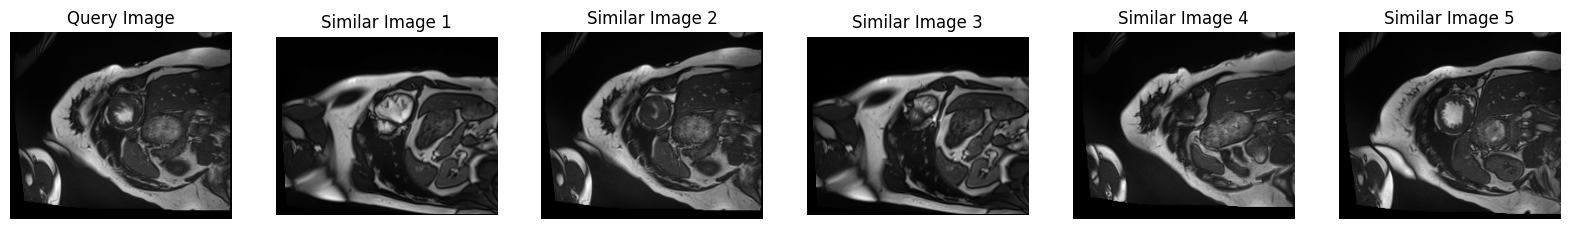

In [39]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient027_frame01_slice_8.png"  
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)


# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_1.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient099_frame09_slice_2.png
Similarity scores: [0.9937554  0.9830689  0.9726658  0.96841544 0.95731217]


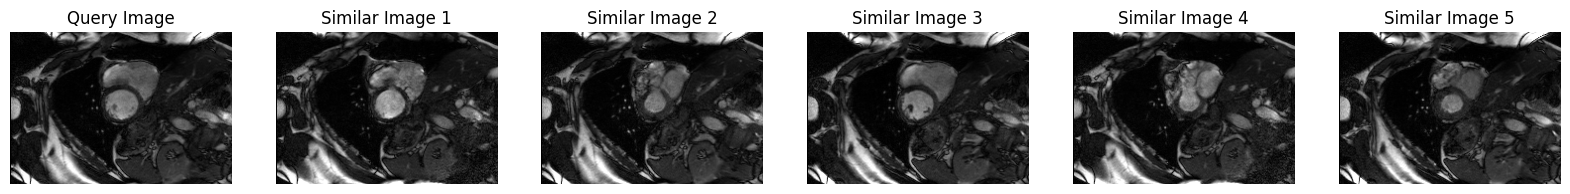

In [40]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient099_frame01_slice_1.png"
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_5.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient061_frame10_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient014_frame13_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/patient061_frame10_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient031_frame01_slice_4.png
Similarity scores: [0.94354844 0.9210775  0.90633976 0.8885471  0.8826428 ]


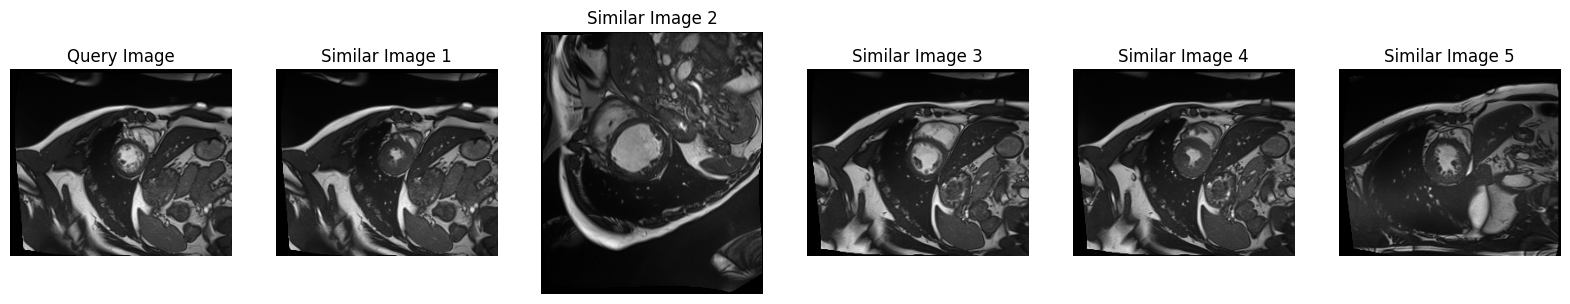

In [41]:
# Query Image
query_image_path = "/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/patient061_frame01_slice_5.png"
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings, top_k=6)
print("Query Image: ",query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images, top_k_indices[1:])


In [69]:
images_test[:10]

['output_data/Testing/ed/images/patient120_frame01_slice_2.png',
 'output_data/Testing/ed/images/patient134_frame01_slice_6.png',
 'output_data/Testing/ed/images/patient139_frame01_slice_1.png',
 'output_data/Testing/ed/images/patient116_frame01_slice_7.png',
 'output_data/Testing/ed/images/patient140_frame01_slice_16.png',
 'output_data/Testing/ed/images/patient122_frame01_slice_5.png',
 'output_data/Testing/ed/images/patient132_frame01_slice_2.png',
 'output_data/Testing/ed/images/patient133_frame01_slice_7.png',
 'output_data/Testing/ed/images/patient132_frame01_slice_9.png',
 'output_data/Testing/ed/images/patient108_frame01_slice_6.png']

Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_3.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient121_frame01_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient121_frame10_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient121_frame10_slice_2.png
Similarity scores: [0.9680189  0.96467584 0.9628035  0.9078002  0.89057577]


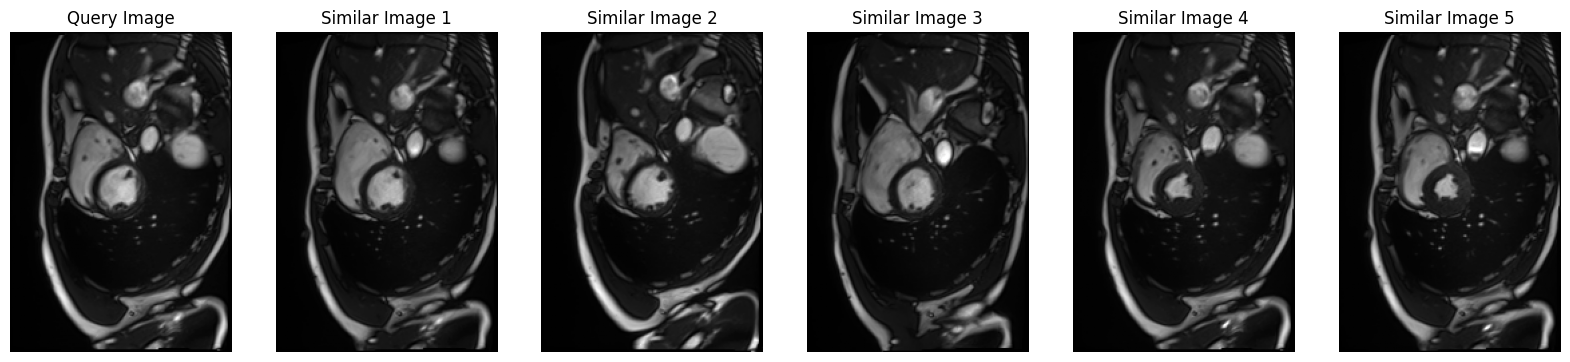

In [79]:
# Query Image
query_image_path = images_test[0]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

# Retrieve most similar images
top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)

Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_7.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_7.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient115_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_5.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient115_frame13_slice_8.png
Similarity scores: [0.9991859  0.980009   0.97352725 0.9715891  0.957913  ]


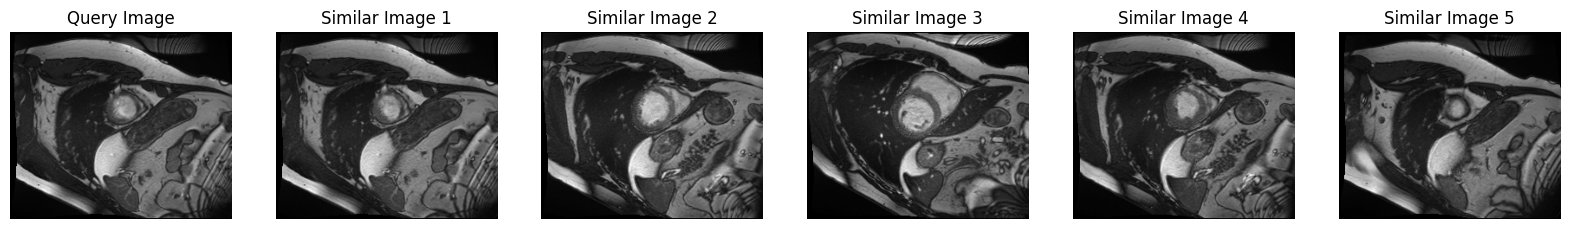

In [80]:
# Query Image
query_image_path = images_test[2]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)


top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_0.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_0.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_2.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient110_frame01_slice_1.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient110_frame11_slice_2.png
Similarity scores: [0.9930255  0.88022244 0.8601348  0.8593522  0.851839  ]


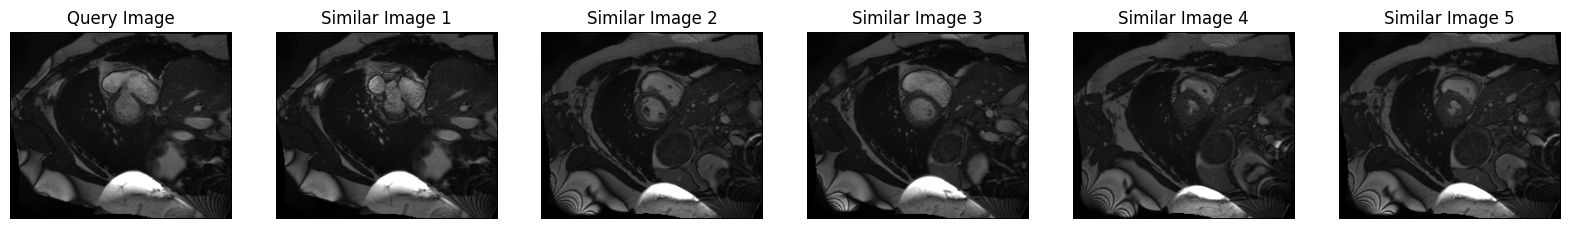

In [81]:
# Query Image
query_image_path = images_test[6]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


Query Image:  /home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_5.png
Most similar images:
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_4.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_6.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/ed/images/patient141_frame01_slice_3.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient140_frame09_slice_15.png
/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Testing/es/images/patient141_frame11_slice_7.png
Similarity scores: [0.9871036  0.98080724 0.95826024 0.9439829  0.93603814]


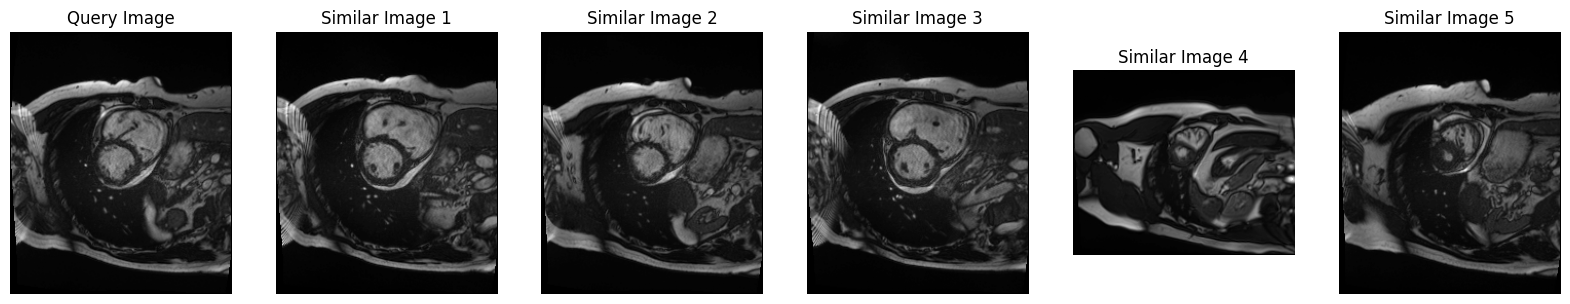

In [90]:
# Query Image
query_image_path = images_test[30]
query_image = Image.open(query_image_path)
query_embedding = get_embedding(model, query_image, transform, device)

top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)
print('Query Image: ',query_image_path)
print("Most similar images:")
for idx in top_k_indices[1:]:
    print(database_images_Test[idx])
# [database_images[idx] for idx in top_k_indices]
print("Similarity scores:", similarities[1:])


# Show query and top similar images
show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path=query_image_path.split("/")[-1],show=True)


In [72]:
# mkdir Test_results

In [77]:
# for i in tqdm(range(len(images_test))):
#     # Query Image
#     query_image_path = images_test[i]
#     query_image = Image.open(query_image_path)
#     query_embedding = get_embedding(model, query_image, transform, device)
    
#     top_k_indices, similarities = retrieve_similar_images(query_embedding, database_embeddings_test,top_k=6)

#     show_query_and_results(query_image_path, database_images_Test, top_k_indices[1:],save_path='Test_results/'+query_image_path.split("/")[-1])
    
